这里 我们使用普通RNN和SegRNN架构对比patch的作用

为什么要进行Patch？

我们希望收集一个长序列的信息

我们可以将RNN类的模型理解为一个顺序的信息收集器，这个收集器可以从前向后逐步遍历所有的时间步，

在每个时间步上，得到的信息储存是之前的历史信息+本次收集的信息，在最后用收集的信息进行输出

因为提升预测的需要，我们必须扩展序列长度，来获取更全面的信息；

但是如果总的距离过长，就必须压缩历史信息的占比，导致远距离信息微弱甚至丢失

而如果不压缩历史信息，会导致梯度爆炸。

因此我们可以参考CNN的思路，采用1维卷积的方式尝试解决这个问题：

首先，我们将原始序列分为长度为某个值子序列，然后每若干步采样一次。

在每个子序列内，可以使用Linear或RNN，尝试在序列中识别出小段的上涨趋势、下跌趋势和平盘之类的信息，并抽象为信息向量；

由于每个子序列内长度有限，RNN可以充分吸取信息而不必担心长序列信息丢失的问题。

如果此时的序列仍然过长，我们可以再加入一层，将上一层得到的子序列再分组为新的子序列，同样用Linear或RNN收集子序列信息。

在这一层我们可以识别出更复杂的形态组合，例如连续多端上涨之后的下跌，抑或是平盘之后的变盘形态等等。

直到整个序列的长度已经很小了，此时我们再使用RNN进行最后一次收集，并将的得到的信息向量传入输出层输出出我们需要的任务。

这样一来，每层的RNN都面对一个相对较小的子序列，不至于出现长距离信息丢失的问题

而不同层的RNN处理的问题是不一样的，其参数和方式也有所不同

In [1]:
import os
os.chdir('d:/future/Index_Future_Prediction')

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import lr_scheduler, Adam, AdamW
from torch.utils.data import TensorDataset, DataLoader

from utils.random_split import RandomSplit, CallableDataset
from utils.back_test import BackTest
from utils.hybrid_loss import HybridLoss
from utils.hybrid_decoder import HybridDecoder
from utils.prediction_recorder import PredictionRecorder
from utils.train_animator import TrainAnimator
from utils.model_train import ModelTrain
from utils.balance_sampler import BalancedSampler

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
feature_columns = ['inday_chg_open','inday_chg_high','inday_chg_low','inday_chg_close','inday_chg_amplitude', 'ma_10','ma_26','ma_45','ma_90','ma_vol',]
label_columns = ['label_return','down_prob','middle_prob','up_prob']
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX', 'AU.SHF', 'JM.DCE','RB.SHF','HC.SHF', 'I.DCE', 'M.DCE', 'CF.ZCE',]
assets_list = ['IH.CFX', 'IF.CFX', 'IC.CFX',]

In [3]:
seq_len = 40
pred_len = 5
train_ratio = 0.5
validation_ratio = 0.2
test_ratio = 0.03

hidden_size = 10
num_layers = 1

In [4]:
feature = []
label = []

for asset_code in assets_list:
    data = pd.read_csv(f'data/{asset_code}.csv')
    feature.append(torch.tensor(data[feature_columns].values, dtype = torch.float32, device = 'cuda:0'))
    label.append(torch.tensor(data[label_columns].values, dtype = torch.float32, device = 'cuda:0'))

# 加载数据
feature = torch.stack(feature, dim = 1)
label = torch.stack(label, dim = 1)
print(feature.shape, label.shape)

# 折叠时间步
feature = feature.unfold(dimension = 0, size = seq_len, step = 1).transpose(2,3)
label = label[seq_len-1:]
# 归并品种
feature = torch.flatten(feature, start_dim=0, end_dim = 1)
label = torch.flatten(label, start_dim=0, end_dim = 1)

feature.shape, label.shape

torch.Size([2603, 3, 10]) torch.Size([2603, 3, 4])


(torch.Size([7692, 40, 10]), torch.Size([7692, 4]))

In [5]:
recorder = PredictionRecorder()
animator = TrainAnimator(figsize=(12,6))

Animator data has been reset.


In [6]:
class SimplePatch(nn.Module):
    """"
    Simple Patch for RNN
    服务于RNN的时间序列分块，因为RNN不会忽略位置信息，因此不需要嵌入RoPE
    """
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def forward(self, x):
        """"
        倒数第二个维度为需要patch的时间步
        """
        # 保存形状并展平前面的层
        front_size = tuple(x.shape[:-2])
        seq_len = x.shape[-2]
        feature_size = x.shape[-1]
        x_rebatch = x.reshape(-1, seq_len, feature_size)


        # 舍去前面无法被整分为patch的的部分
        max_patch = seq_len//self.patch_size
        vaild_seq_len = self.patch_size * max_patch
        x_valid = x_rebatch[:,-vaild_seq_len:,:].clone() # 切片操作破坏了内存连续性，需要复制一份
        x_recover = x_valid.reshape(*front_size, max_patch, self.patch_size, feature_size)

        return x_recover
    
if __name__ == '__main__':
    x = torch.randn(size = (5,7,20,9))
    sp = SimplePatch(6)
    print(sp(x).shape)

torch.Size([5, 7, 3, 6, 9])


In [7]:
class SequenceTruncate(nn.Module):
    """
    随机从序列中裁去前端的一部分时间步，在保持序列整体顺序结构不变的情况下丰富输入的信息，进一步降低过拟合的影响，类似于时间序列上的dropout
    """
    def __init__(self, dropout):
        """
        警告：dropout 过大，可能导致序列过短无法完成其他基础任务
        """
        super().__init__()
        self.dropout = dropout

    def forward(self, x):
        if self.training:
            front_size = tuple(x.shape[:-2])
            seq_len = x.shape[-2]
            feature_size = x.shape[-1]
            x_rebatch = x.reshape(-1, seq_len, feature_size)

            random_drop = torch.randint(0, int(self.dropout*seq_len) + 1, (1,), device=x.device).item() # dropout 为最大舍弃比例，会随即从0到dropout舍弃一定比例

            x_valid = x_rebatch[:,random_drop:,:].clone() # 切片操作破坏了内存连续性，需要复制一份
            x_recover = x_valid.reshape(*front_size, seq_len - random_drop, feature_size)
            return x_recover

        else:
            return x
        
if __name__ == '__main__':
    x = torch.randn(size = (5,7,20,9))
    st = SequenceTruncate(0.5)
    print(st(x).shape)

torch.Size([5, 7, 20, 9])


In [8]:
class Patch_LSTM(nn.Module):
    """循环神经网络模型"""
    def __init__(self, input_size, patch_size, in_patch_hidden_size, inpatch_num_layers, hidden_size, num_layers, dropout):
        super().__init__()
        self.device = 'cuda:0'
        self.input_size = input_size
        self.patch_size = patch_size
        self.in_patch_hidden_size = in_patch_hidden_size
        self.hidden_size = hidden_size

        self.sequence_truncate = SequenceTruncate(dropout)

        self.simple_patch = SimplePatch(patch_size)

        self.inpatch_process = nn.RNN(
            input_size = input_size,
            hidden_size = in_patch_hidden_size,
            num_layers = inpatch_num_layers,
            dropout = dropout,
            batch_first = True,
            # nonlinearity='relu',
        )
        self.dropout = nn.Dropout(dropout)

        self.process = nn.LSTM(
            input_size = in_patch_hidden_size, #第一层LSTM的隐藏层作为第二层的输入，因此第二层的input size = in_patch_hidden_size
            hidden_size = hidden_size,
            num_layers = num_layers,
            dropout = dropout,
            batch_first = True,
            # nonlinearity='relu',
        )
        
        self.output = nn.Sequential(
            nn.Dropout(dropout),
            HybridDecoder(dim_state = hidden_size, init_prob = [0.0,0.5,0.0])
        )
        

    def forward(self, x):

        x_truncated = self.sequence_truncate(x)
        x_patched = self.simple_patch(x_truncated)
        num_patch = x_patched.shape[-3]
        front_size = tuple(x_patched.shape[:-2])
        x_rebatched = x_patched.reshape(-1, self.patch_size, self.input_size)
        x_processed_1 = self.inpatch_process(x_rebatched)[0][:,-1,:]
        x_recover = x_processed_1.reshape(*front_size, -1)
        front_size_2 = tuple(x_recover.shape[:-2])
        x_rebatched_2 = x_recover.reshape(-1, num_patch,  self.in_patch_hidden_size)
        x_rebatched_2 = self.dropout(x_rebatched_2)
        x_processed_2 = self.process(x_rebatched_2)[0][:,-1,:]
        x_recover_2 = x_processed_2.reshape(*front_size_2, self.hidden_size)
        
        return self.output(x_recover_2)

if __name__ == '__main__':
    x = torch.randn(size = (7,40,9))
    model = Patch_LSTM(input_size = 9, patch_size = 6, in_patch_hidden_size = 12, inpatch_num_layers = 2, hidden_size = 11, num_layers = 3, dropout = 0.5)
    print(model(x).shape)

torch.Size([7, 4])


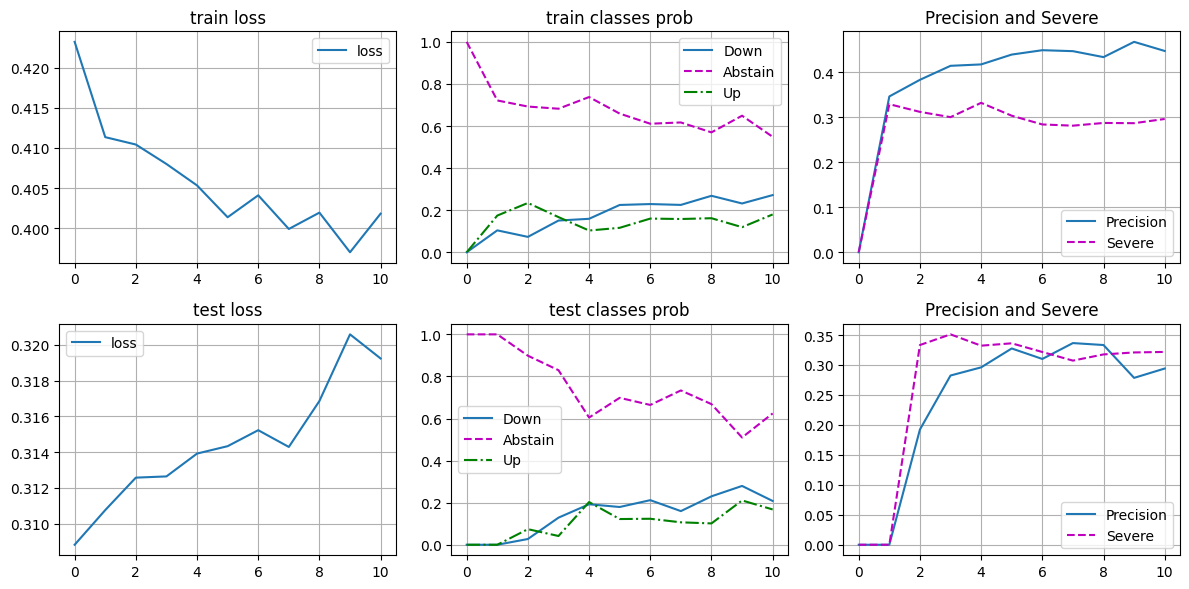

100%|██████████| 8/8 [00:00<00:00, 342.80it/s]


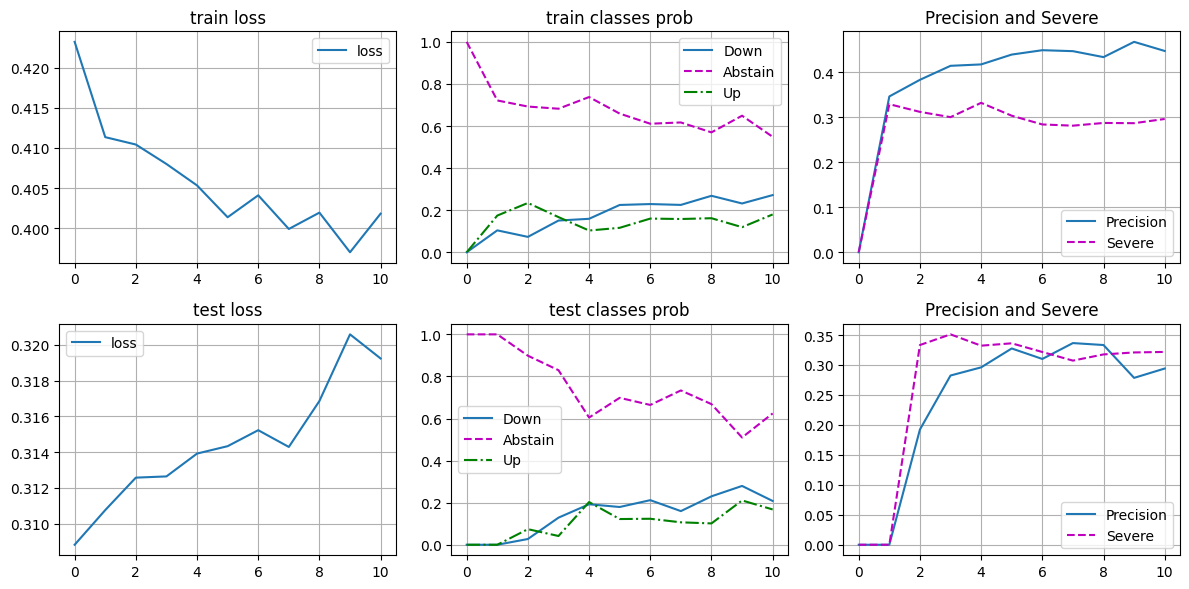

In [9]:
result = np.zeros(shape = (10, len(assets_list), 4))

for i in range(10):
    j = 0
    train_size = int(0.5*len(feature))
    validation_size = int(0.1*len(feature))
    test_size  = int(0.1*len(feature))

    split = np.random.randint(train_size, len(feature) - validation_size - test_size)

    train_set = TensorDataset(feature[:split], label[:split])
    balance_sampler = BalancedSampler(label[:split], 128)
    train_loader = DataLoader(train_set, batch_sampler=balance_sampler)

    validation_set = TensorDataset(feature[split:split+validation_size], label[split:split+validation_size])
    validation_loader = DataLoader(validation_set, batch_size=100)

    test_set = TensorDataset(feature[split+validation_size:split+validation_size+test_size], label[split+validation_size:split+validation_size+test_size])
    test_loader = DataLoader(test_set, batch_size=100)

    
    animator.reset()
    loss_fn = HybridLoss(alpha = 5e-2, delta = 1.3, show_loss = False)
    model = Patch_LSTM(input_size = 10, patch_size = 10, in_patch_hidden_size = 7, inpatch_num_layers = 1, hidden_size = 7, num_layers = 1, dropout = 0.4).to('cuda:0')
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-3, weight_decay = 1e-1)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)
    train = ModelTrain(model = model,
                   train_loader = train_loader,
                   validation_loader = validation_loader,
                   test_loader = test_loader,
                   loss_fn = loss_fn,
                   optimizer = optimizer,
                   scheduler = scheduler,
                   recorder = recorder,
                   graph = animator,
                   )
    prediction, precision = train.epoch_train(epochs = 30, early_stop = 100)

    result[i,j,0] = prediction
    result[i,j,1] = precision

In [10]:
all_assets = pd.DataFrame({
    'stage_1_prediction': np.mean(result, axis = 0)[:,0],
    'stage_2_prediction': np.mean(result, axis = 0)[:,2],

    'stage_1_precision': np.mean(result, axis = 0)[:,1],
    'stage_2_precision': np.mean(result, axis = 0)[:,3],

    'stage_1_precision_std': np.std(result, axis = 0)[:,1],
    'stage_2_precision_std': np.std(result, axis = 0)[:,3],
})
all_assets.index = pd.Series(assets_list)
for col in all_assets.columns:
    all_assets[col] = all_assets[col].apply(lambda x: f"{x:.1%}")

# 转换为Markdown
markdown_table = all_assets.to_markdown(index=False)
print(f'hidden_size: {hidden_size}, num_layers: {num_layers}, seq_len: {seq_len}')
print(markdown_table)

hidden_size: 10, num_layers: 1, seq_len: 40
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 37.7%                | 0.0%                 | -3.8%               | 0.0%                | 6.7%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |


benchmark
| stage_1_prediction   | stage_2_prediction   | stage_1_precision   | stage_2_precision   | stage_1_precision_std   | stage_2_precision_std   |
|:---------------------|:---------------------|:--------------------|:--------------------|:------------------------|:------------------------|
| 21.9%                | 0.0%                 | 15.8%               | 0.0%                | 14.0%                   | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |
| 0.0%                 | 0.0%                 | 0.0%                | 0.0%                | 0.0%                    | 0.0%                    |